In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [2]:
def showLabel(image):
    image_ids = set(image[image>0])
    colors = {}
    for _id in image_ids:
        colors[_id] = [int(np.random.random()*255), int(np.random.random()*255), int(np.random.random()*255)]
    Unlabelled = [0,0,0]
    r = image.copy()
    g = image.copy()
    b = image.copy()
    for l in image_ids:
        r[image==l] = colors[l][0]
        g[image==l] = colors[l][1]
        b[image==l] = colors[l][2]
    rgb = np.zeros((image.shape[0], image.shape[1], 3))
    rgb[:,:,0] = r/1.0
    rgb[:,:,1] = g/1.0
    rgb[:,:,2] = b/1.0
    return np.uint8(rgb)

## Reading tfrecord
Using string_input_producer to read given tfrecord.
In real case, you should use the collection of tfrecord by glob.glob("path/to/tfrecord/*.tfrecord")

tf.parse_single_example is corresponding to how the tfrecord is written (previous example)

In [3]:
train_data_path = "/data/dataset/coco/records/coco_train2014_00000-of-00010.tfrecord"
filename = train_data_path
filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(serialized_example,
            features={
                'image/img_id': tf.FixedLenFeature([], tf.int64),
                'image/encoded': tf.FixedLenFeature([], tf.string),
                'image/height': tf.FixedLenFeature([], tf.int64),
                'image/width': tf.FixedLenFeature([], tf.int64),
                'label/num_instances': tf.FixedLenFeature([], tf.int64),
                'label/gt_masks': tf.FixedLenFeature([], tf.string),
                'label/gt_boxes': tf.FixedLenFeature([], tf.string),
                'label/encoded': tf.FixedLenFeature([], tf.string),
            })

## Reconstruct Tensor
We use image_height, image_width, num_instance to reconstruct original image.
Noted that image could be gray-scale and various size.

Because tf.train.shuffle_batch cannot feed unknown shape tensor (not pre-defined), so we consturct our own random-shuffle batch (Maybe there is another workaround ?)

In [4]:
img_id = tf.cast(features['image/img_id'], tf.int32)
image_height = tf.cast(features['image/height'], tf.int32)
image_width = tf.cast(features['image/width'], tf.int32)
num_instances = tf.cast(features['label/num_instances'], tf.int32)
image = tf.decode_raw(features['image/encoded'], tf.uint8)
imsize = tf.size(image)
# To see if this image is gray-scale
image = tf.cond(tf.equal(imsize, image_height * image_width), \
      lambda: tf.image.grayscale_to_rgb(tf.reshape(image, (image_height, image_width, 1))), \
      lambda: tf.reshape(image, (image_height, image_width, 3)))

gt_boxes = tf.decode_raw(features['label/gt_boxes'], tf.float32)
gt_boxes = tf.reshape(gt_boxes, [num_instances, 5])
# Above reshape op with give error when queue is running (see below), dont know why, but still work. 
gt_masks = tf.decode_raw(features['label/gt_masks'], tf.uint8)
gt_masks = tf.cast(gt_masks, tf.int32)
gt_masks = tf.reshape(gt_masks, [num_instances, image_height, image_width])
batch_size = 1
# batch_size should be a hyper-param in real cases
data_queue = tf.RandomShuffleQueue(capacity=100*batch_size, min_after_dequeue=10*batch_size,
            dtypes=(
                image.dtype, image_height.dtype, image_width.dtype, 
                gt_boxes.dtype, gt_masks.dtype, 
                num_instances.dtype, img_id.dtype))

enqueue_op = data_queue.enqueue((image, image_height, image_width, gt_boxes, gt_masks, num_instances, img_id))

data_queue_runner = tf.train.QueueRunner(data_queue, [enqueue_op] * 4)
tf.add_to_collection(tf.GraphKeys.QUEUE_RUNNERS, data_queue_runner)
# (image, image_height, image_width, gt_boxes, gt_masks, num_instances, img_id)
(image, image_height, image_width, gt_boxes, gt_masks, num_instances, img_id) = data_queue.dequeue()


(640, 427, array([[  22.95999908,  175.07000732,  276.95001221,  532.38000488,    1.        ],
       [ 110.66000366,  508.47000122,  303.17999268,  549.59997559,   37.        ]], dtype=float32))
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, Input to reshape is a tensor with 1 values, but the requested shape has 0
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](DecodeRaw_1/_13, Reshape/shape)]]
	 [[Node: Reshape/_41 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_81_Reshape", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
END!


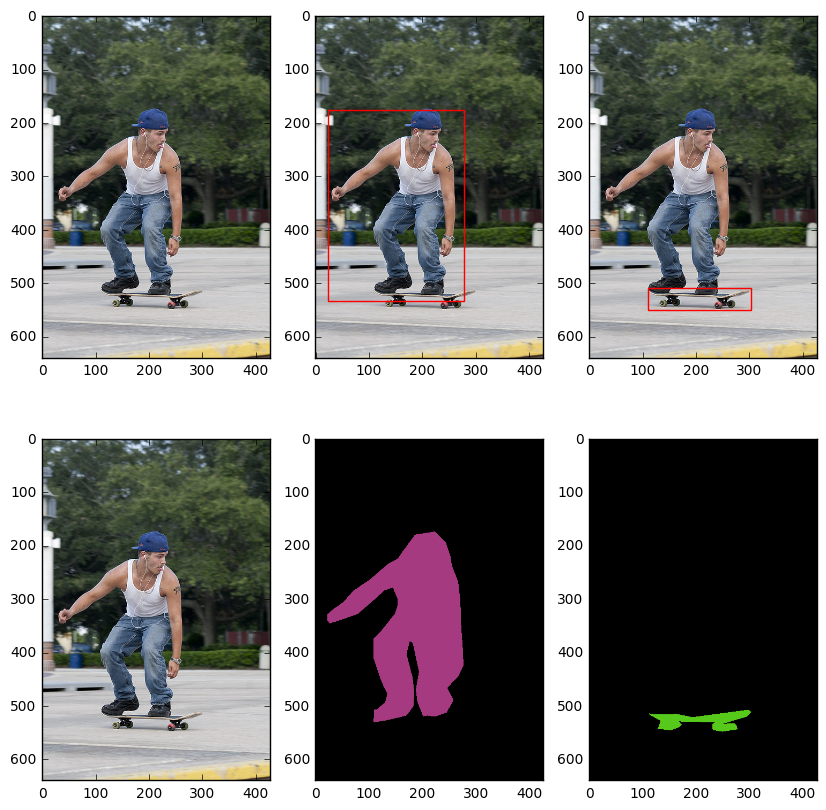

In [5]:
sess = tf.Session()
sess.run(tf.local_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
for i in range(1):
    im ,h, w, gt_b, gt_m = sess.run([image, image_height, image_width, gt_boxes, gt_masks])
    print(h, w, gt_b)
    # show instance mask and bounding box
    f, axarr = plt.subplots(2, len(gt_m)+1)
    axarr[0,0].imshow(im)
    axarr[1,0].imshow(im)
    for ind, bb in enumerate(gt_b):
        bw = bb[2] - bb[0]
        bh = bb[3] - bb[1]
        rect = patches.Rectangle((bb[0], bb[1]), bw, bh, linewidth=1, edgecolor='r', facecolor='none')
        axarr[0, ind+1].imshow(im)
        axarr[0, ind+1].add_patch(rect)
    for ind, m in enumerate(gt_m):
        axarr[1, ind+1].imshow(showLabel(m))

print("END!")